In [225]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Inspect the data


In [226]:
example_data = pd.read_csv("kaggle/input/deep-learning-for-msc-2022-23/example.csv")
example_data.head()

,Filename,Label
0,10001.png,0
1,10002.png,0
2,10003.png,0
3,10004.png,0
4,10005.png,0


In [227]:
train_data = pd.read_csv('kaggle/input/deep-learning-for-msc-2022-23/train.csv')
train_data.head()

,Filename,Label
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0


In [228]:
img_name = train_data['Filename'].iloc[2]
Label = train_data['Label'].iloc[0]
print(img_name)
print(Label)

img = io.imread(r'kaggle\input\deep-learning-for-msc-2022-23\train\\'+img_name)



3.png
0


## Display image



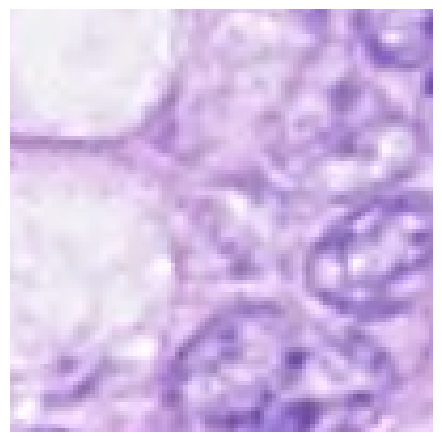

In [229]:
def show_Label(image,Label):
    """Show image with Label"""
    plt.imshow(image)
    plt.tight_layout()
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_Label(io.imread(os.path.join('kaggle/input/deep-learning-for-msc-2022-23/train/', img_name)), Label)
plt.show()

## Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample.

Let's create a dataset class for our face Label dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'Label': Label}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




In [230]:
class LabelDataset(Dataset):
    """Face Label dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imgs = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.imgs['Filename'].iloc[idx])
        
        image = io.imread(img_name)
        Label = self.imgs['Label'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
            Label = torch.tensor(Label)
        
        sample = {'image': image, 'Label': Label}

        # if self.transform:
        #     sample = self.transform(sample)

        return sample

0 (100, 100, 3) 0


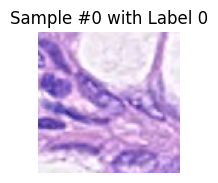

1 (100, 100, 3) 0


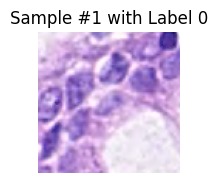

2 (100, 100, 3) 0


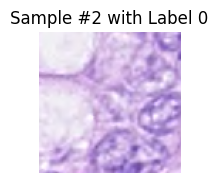

3 (100, 100, 3) 0


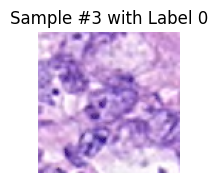

In [232]:
face_dataset = LabelDataset(csv_file=r'kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                    root_dir=r'kaggle/input/deep-learning-for-msc-2022-23/train')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['Label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i) +' with Label ' +f'{Label}')
    ax.axis('off')
    show_Label(**sample)

    if i == 3:
        plt.show()
        break

## Data augmentation


In [233]:
# class Rescale(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """

#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, sample):
#         image, Label = sample['image'], sample['Label']

#         h, w = image.shape[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size

#         new_h, new_w = int(new_h), int(new_w)

#         img = transform.resize(image, (new_h, new_w))

#         return {'image': img, 'Label': Label}


# class RandomCrop(object):
#     """Crop randomly the image in a sample.

#     Args:
#         output_size (tuple or int): Desired output size. If int, square crop
#             is made.
#     """

#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size

#     def __call__(self, sample):
#         image, Label = sample['image'], sample['Label']

#         h, w = image.shape[:2]
#         new_h, new_w = self.output_size
#         top = np.random.randint(0, h - new_h)
#         left = np.random.randint(0, w - new_w)

#         image = image[top: top + new_h,
#                       left: left + new_w]



#         return {'image': image, 'Label': Label}


# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, sample):
#         image, Label = sample['image'], sample['Label']

#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C x H x W
#         image = image.transpose((2, 0, 1))
#         return {'image': torch.from_numpy(image),
#                 'Label': Label}

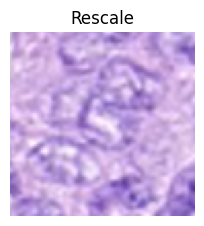

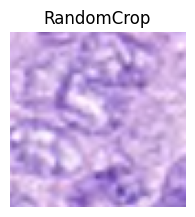

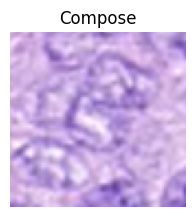

In [234]:
scale = Rescale(90)
crop = RandomCrop(80)
composed = transforms.Compose([Rescale(90), RandomCrop(80)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_Label(**transformed_sample)
plt.show()

In [235]:
transformed_dataset = LabelDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\train.csv',
                                           root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\train',
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Resize(100),
                                               transforms.RandomCrop(64)
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['Label'])

    if i == 3:
        break

0 torch.Size([3, 64, 64]) tensor(0)
1 torch.Size([3, 64, 64]) tensor(0)
2 torch.Size([3, 64, 64]) tensor(0)
3 torch.Size([3, 64, 64]) tensor(0)


In [236]:
dataloader = DataLoader(transformed_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_Label_batch(sample_batched):
    """Show image with Label for a batch of samples."""
    images_batch, Label_batch = \
            sample_batched['image'], sample_batched['Label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0. 



0 torch.Size([1, 3, 64, 64]) torch.Size([1])
1 torch.Size([1, 3, 64, 64]) torch.Size([1])
2 torch.Size([1, 3, 64, 64]) torch.Size([1])
3 torch.Size([1, 3, 64, 64]) torch.Size([1])


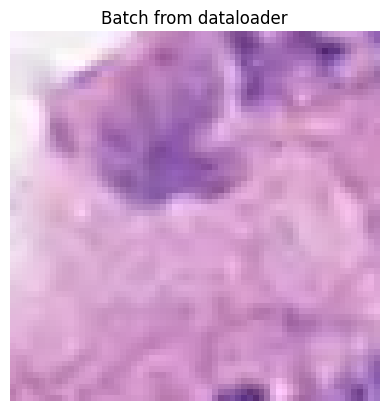

In [237]:
# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['Label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_Label_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Build the network

This is all from lab 3 which discusses how to build a convolutional neural network.

64(channels)*64*64(img dimensions)/4(max pooling) = 65536

whish is used in the linear layer

In [238]:
import collections

model = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv2d(3,20,3,padding=1)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20,64,3,padding=1)),
          ('relu2', nn.ReLU()),
          ('pool1',nn.MaxPool2d(2,2)),

          ('flatten', nn.Flatten()),                                          
          ('fc1', nn.Linear(65536,1000)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(1000,5)),
        ]))



In [239]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for item in train_loader:
            imgs=item['image']
            labels = item['Label']
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [240]:
import torchvision

lr = 0.01

# we set the optimiser as Stochastic Gradient Descent for both networks, 
# you could also try Adam
optimizer = optim.SGD(model.parameters(), lr=lr)

#optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer_dense = optim.Adam(model_dense.parameters(), lr=lr)

# set the loss function to optimise. Cross Entropy is usually the best for 
# classification
loss_fn = nn.CrossEntropyLoss()

In [241]:
n_epochs = 2
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# train the CNN
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = dataloader,
)


KeyboardInterrupt: 